<a href="https://colab.research.google.com/github/YokoyamaLab/PythonBasics/blob/2024/day08_q2FromOriginalImages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
from google.colab import drive
drive.mount("/content/gdrive")

dir = "/content/images/"
dir_original = "/content/img/"

# Gdrive上からGoogle Colabの環境にダウンロードする
!cp -r "/content/gdrive/Shareddrives/2024-35A01／情報科学 e／横山 昌平/img" "/content"
# 学習用データのサイズに縮小した画像を保存するディレクトリの作成
!mkdir "images"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
mkdir: cannot create directory ‘images’: File exists


In [44]:
import os
import re
from PIL import Image
import numpy as np
import pprint

# ファイル名の一覧を取得（この講義では教えていないPython特有の書き方をしてみました）
files = [
    f for f in os.listdir(dir_original) if os.path.isfile(os.path.join(dir_original, f))
]
# とりあえずファイル一覧を表示してみる
print(files)

# 学習用画像のサイズ(一辺のピクセル数)
size = 8

# 数字毎にファイルパスを格納しておく辞書型の変数を準備する
images = []
numbers =  []
# originalディレクトリの画像ファイルを縮小してimagesに入れる
for file in files:
  try:
    # ファイルを開く
    img = Image.open(dir_original + file)
    # ファイルを指定されたサイズでリサイズし白黒化する
    img_resized = img.resize((size, size),Image.ANTIALIAS).convert('L')
    # 小さくしたファイルを保存する
    img_resized.save(dir + file, quality=90)
    # 正規表現で学籍番号、番号、拡張子に分割する
    student,number,extension = re.split('[_.]', file)
    # 画像は二次元配列なのでこれを一次元化しimagesに追加
    images.append(np.asarray(img_resized).flatten())
    # 画像が表す数もnumbersに追加
    numbers = np.append(numbers,int(number))
  # PILで画像として読めないファイルだった時
  except Image.UnidentifiedImageError:
    print(file,"読めない画像形式なのでスキップします")

# imagesをnumPy配列に変換
images =  np.asarray(images,dtype=float)
# このままだと0～255のグレースケール画像なので、
# 教科書で使っているsklearn.datasetsのload_digitsと同様に0(黒)～16(白)に変換
images = 16 - np.floor(17*images/256)


['G22930_9.png', 'G22947_7.png', 'G22938_7.png', 'G29918_0.png', 'G22938_8.png', 'G22906_7.png', 'G20922_6.png', 'G22952_8.png', 'G22947_3.png', 'G22916_6.png', 'G22922_3.png', 'G22906_5.png', 'G22930_10.png', 'G22940_0.png', 'G22916_1.png', 'G22922_1.png', 'G20932_8.png', 'G22922_9.png', 'G22916_2.png', 'G22936_0.png', 'G21948_1.png', 'G22924_3.png', 'g22951_6.png', 'G22939_5.png', 'G22932_4.png', 'G21948_8.png', 'G22921_2.png', 'G22927_6.png', 'G22932_7.png', 'G22937_4.png', 'G22909_9.png', 'G22952_0.png', 'G22921_1.png', 'G22932_6.png', 'G22929_3.png', 'G22924_6.png', 'G22946_6.png', 'G22949_1.png', 'G22952_2.png', 'G22930_3.png', 'G22909_5.png', 'G22916_7.png', 'G22930_5.png', 'G22916_4.png', 'G22938_5.png', 'G22940_8.png', 'G22921_7.png', 'G22936_7.png', 'G22946_4.png', 'G22909_2.png', 'G22936_6.png', 'G22929_5.png', 'G22930_6.png', 'G22924_7.png', 'G22932_9.png', 'G22906_6.png', 'G22916_0.png', 'G21929_4.png', 'G22929_6.png', 'G22907_7.png', 'G22932_8.png', 'G22926_4.png', 'G2292

<ipython-input-44-c8622e0d4a90>:26: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img_resized = img.resize((size, size),Image.ANTIALIAS).convert('L')


G22921_4.png 読めない画像形式なのでスキップします


In [45]:
import matplotlib.pyplot as plot



In [46]:
from sklearn.model_selection import train_test_split

# ここで『Xからyを予測する』という機械学習に取り組む
# つまり画像(を配列にしたもの)から画像に書かれている数字を予測する
X = images
y = numbers

# 訓練データとテストデータに分ける(学習した画像とは違う画像で制度を検証するため)
X_train,X_test,y_train,y_test= train_test_split(X,y)
# 何も指定しないと25%がテストデータとなり75%が訓練データとなる
# 以下のように明示的に割合を変える事も可能
# X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.6)

print("訓練データ数: ", len(X_train))
print("テストデータ数: ",len(X_test))

np.savetxt('out.csv',X_train,delimiter=',')

訓練データ数:  222
テストデータ数:  75


In [47]:
images

array([[ 2., 12., 16., ...,  0.,  0.,  0.],
       [ 1.,  3.,  1., ...,  0.,  0.,  0.],
       [ 0.,  4.,  6., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [48]:
# 教科書p.180のコードを使って、自前の画像データで
# 学習・推定し、正解率を計測しよう
from sklearn import svm
from sklearn.metrics import accuracy_score

model = svm.SVC(kernel="rbf", gamma=0.001)
model.fit(X_train,y_train)

pred = model.predict(X_test)
score = accuracy_score(y_test, pred)

print("正解率: ",score*100,"%")

正解率:  88.0 %


In [51]:
import pandas as pd
from sklearn.datasets import load_digits

sklearn_dataset = load_digits()
sklearn_images = sklearn_dataset.data
sklearn_numbers = sklearn_dataset.target

X_train_plus = np.concatenate([X_train, sklearn_images])
y_train_plus = np.concatenate([y_train, sklearn_numbers])


In [56]:
from PIL import Image
import matplotlib.pyplot as plt

model = svm.SVC(kernel="rbf", gamma=0.001)
model.fit(X_train_plus,y_train_plus)

pred = model.predict(X_test)
score = accuracy_score(y_test, pred)

print("正解率: ",score*100,"%")


正解率:  85.33333333333334 %


【間違い！】推定: 3 正解: 5


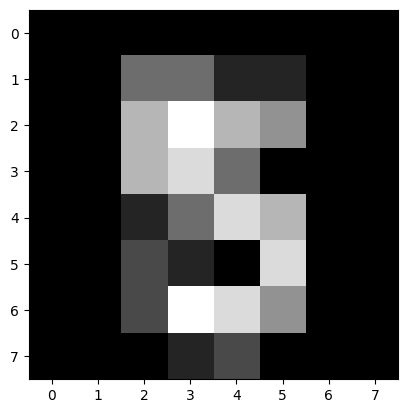

【間違い！】推定: 2 正解: 3


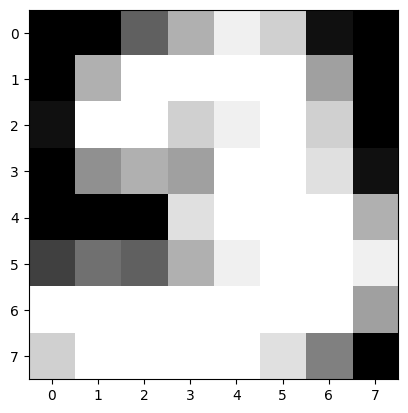

【間違い！】推定: 5 正解: 8


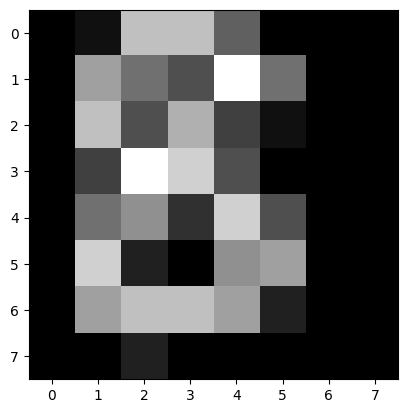

【間違い！】推定: 9 正解: 7


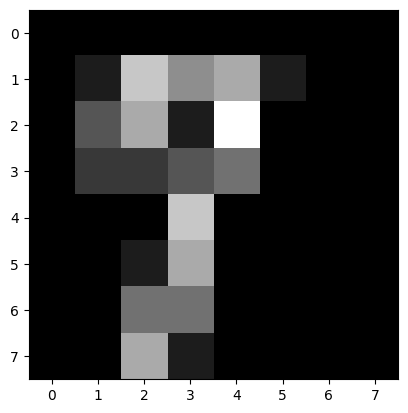

【間違い！】推定: 3 正解: 8


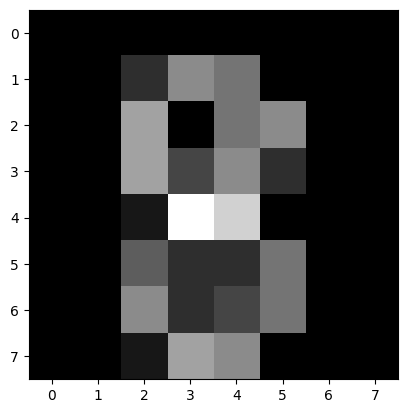

【間違い！】推定: 3 正解: 8


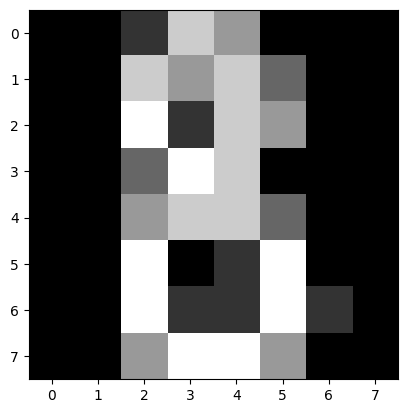

【間違い！】推定: 2 正解: 1


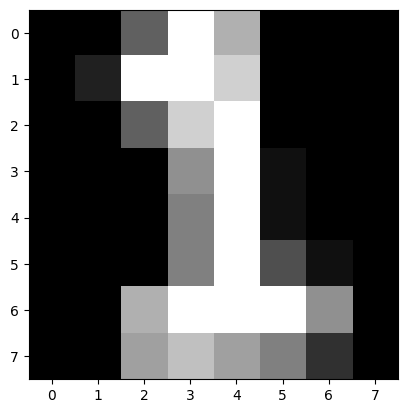

【間違い！】推定: 9 正解: 8


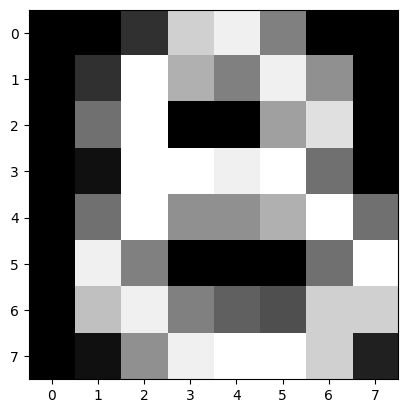

【間違い！】推定: 4 正解: 6


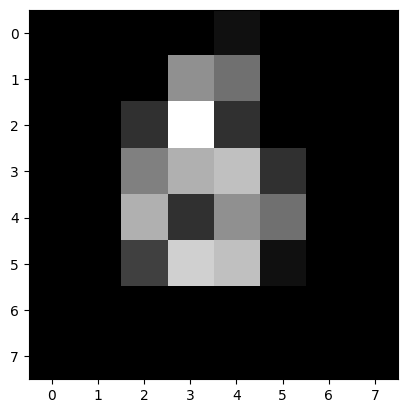

【間違い！】推定: 6 正解: 8


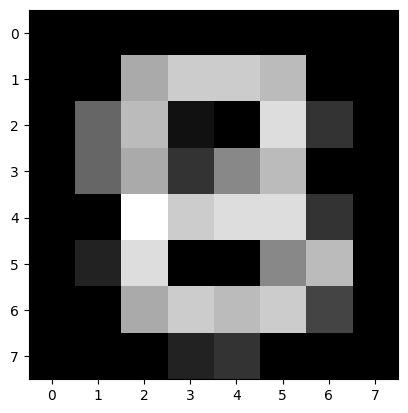

【間違い！】推定: 4 正解: 9


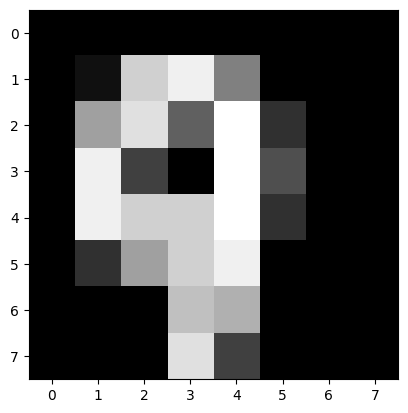

75 画像中 11 個ダメ！ 正解率: 0.8533333333333334 %


In [57]:
dame = 0
for xt in range(len(X_test)):
  pred = model.predict([X_test[xt]])
  if pred[0] != y_test[xt]:
    print("【間違い！】推定:",int(pred[0]),"正解:",int(y_test[xt]))
    img = X_test[xt].reshape([8, 8])
    plt.imshow(img,cmap="gray")
    plt.show()
    dame += 1
print(len(X_test),"画像中",dame,"個ダメ！","正解率:",(len(X_test)-dame)/len(X_test),"%")

## 数字予測　その２

トレーニングした判定器を使って、全く別の画像を判定してみましょう。googleドライブのimg2ディレクトリに、手書きではなくコンピュータで描いた数字の画像が3セットあります。

まずは、これをローカルにもってきます。

In [ ]:
# Gdrive上からGoogle Colabの環境にダウンロードする
!cp -r "/content/gdrive/Shareddrives/2024-35A01／情報科学 e／横山 昌平/img2" "/content"
# 学習用データのサイズに縮小した画像を保存するディレクトリの作成
!mkdir "images2"

さて、これを判定してみましょう。

In [ ]:
## コードをここに